In [19]:
%matplotlib inline 

import os
import sys
sys.path.append(os.path.abspath('../src/'))

import pandas as pd
import numpy as np
import datetime


import matplotlib.pyplot as plt
import seaborn as sns
sns.plotting_context('paper')

from wordGraph import *
from textDataset import *
from trainner import TrainnerNLP

from torchvision import transforms
import networkx as nx

from models import BoWClassifier, Tfid

import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim


In [2]:
subjects=['biology', 'cooking', 'crypto', 'diy', 'robotics', 'travel']
path2data = '../data/'
batch_size = 32

In [3]:
dsets = {
    'train': TextDataset(subjects, path2data + 'train/', is_train = True),
    'valid': TextDataset(subjects, path2data + 'train/', is_valid=True),
    'test':  TextDataset(subjects, path2data + 'test/',  is_test=True),
}

In [4]:
dsets['train'].data.head()

,id,title,content,tags,subject
0,1,What is the criticality of the ribosome bindin...,"<p>In prokaryotic translation, how critical fo...",ribosome binding-sites translation synthetic-b...,biology
1,2,How is RNAse contamination in RNA based experi...,<p>Does anyone have any suggestions to prevent...,rna biochemistry,biology
2,3,Are lymphocyte sizes clustered in two groups?,<p>Tortora writes in <em>Principles of Anatomy...,immunology cell-biology hematology,biology
3,4,How long does antibiotic-dosed LB maintain goo...,<p>Various people in our lab will prepare a li...,cell-culture,biology
4,5,Is exon order always preserved in splicing?,<p>Are there any cases in which the splicing m...,splicing mrna spliceosome introns exons,biology


In [5]:
dsets['train'].process_data(col = 'title', lemmalize = False, stem = False)
dsets['train'].process_data(col = 'content', lemmalize = False, stem = False)

In [6]:
dsets['train'].data.head()

,id,title,content,tags,subject,title_data,content_data
0,1,What is the criticality of the ribosome bindin...,"<p>In prokaryotic translation, how critical fo...",ribosome binding-sites translation synthetic-b...,biology,what criticality ribosome binding site relativ...,in prokaryotic translation critical efficient ...
1,2,How is RNAse contamination in RNA based experi...,<p>Does anyone have any suggestions to prevent...,rna biochemistry,biology,how rnase contamination rna based experiments ...,does anyone suggestions prevent rnase contamin...
2,3,Are lymphocyte sizes clustered in two groups?,<p>Tortora writes in <em>Principles of Anatomy...,immunology cell-biology hematology,biology,are lymphocyte sizes clustered two groups,tortora writes principles anatomy physiology l...
3,4,How long does antibiotic-dosed LB maintain goo...,<p>Various people in our lab will prepare a li...,cell-culture,biology,how long antibiotic-dosed lb maintain good sel...,various people lab prepare liter lb add kanamy...
4,5,Is exon order always preserved in splicing?,<p>Are there any cases in which the splicing m...,splicing mrna spliceosome introns exons,biology,is exon order always preserved splicing,are cases splicing machinery constructs mrna e...


In [ ]:
g_tags = WordsGraph(dsets['train'].data)
g_data = WordsGraph(dsets['train'].data, col = 'content_data', weight = 500)

In [8]:
g_tags.words_df.sort_values('categories_appears', ascending=False).head()

,biology,cooking,crypto,diy,robotics,travel,categories_appears
untagged,6,6,1,35,7,1,6
software,44,5,0,12,54,10,5
history,60,29,35,0,0,39,4
terminology,163,0,121,19,0,120,4
children,10,8,0,0,2,216,4


(-0.95022853136062624,
 0.97714849233627321,
 -1.2004048183560372,
 1.1090221360325814)

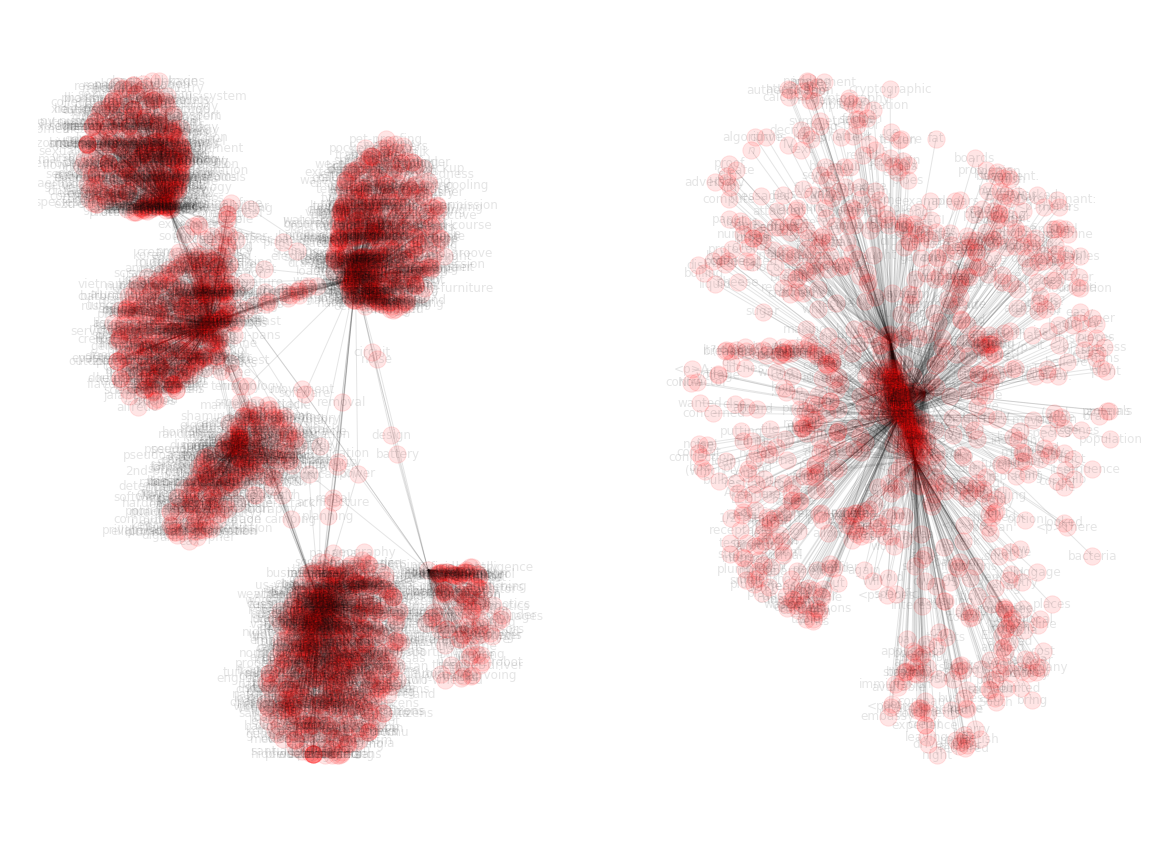

In [9]:
fig = plt.figure(figsize=[20,15])
plt.subplot(1,2,1)
nx.draw_networkx(g_tags.g,alpha=0.1)
plt.axis('off')
plt.subplot(1,2,2)
nx.draw_networkx(g_data.g,alpha=0.1)
plt.axis('off')
#fig.savefig('../figures/word_graph.jpg')

In [7]:
dsets['train'].data.head()

,id,title,content,tags,subject,title_data,content_data
0,1,What is the criticality of the ribosome bindin...,"<p>In prokaryotic translation, how critical fo...",ribosome binding-sites translation synthetic-b...,biology,what criticality ribosome binding site relativ...,in prokaryotic translation critical efficient ...
1,2,How is RNAse contamination in RNA based experi...,<p>Does anyone have any suggestions to prevent...,rna biochemistry,biology,how rnase contamination rna based experiments ...,does anyone suggestions prevent rnase contamin...
2,3,Are lymphocyte sizes clustered in two groups?,<p>Tortora writes in <em>Principles of Anatomy...,immunology cell-biology hematology,biology,are lymphocyte sizes clustered two groups,tortora writes principles anatomy physiology l...
3,4,How long does antibiotic-dosed LB maintain goo...,<p>Various people in our lab will prepare a li...,cell-culture,biology,how long antibiotic-dosed lb maintain good sel...,various people lab prepare liter lb add kanamy...
4,5,Is exon order always preserved in splicing?,<p>Are there any cases in which the splicing m...,splicing mrna spliceosome introns exons,biology,is exon order always preserved splicing,are cases splicing machinery constructs mrna e...


## TF-ID  (unsuppervised approach)

In [8]:
dsets['test'].process_data(col = 'title', lemmalize = False, stem = False)
dsets['test'].process_data(col = 'content', lemmalize = False, stem = False)

In [9]:
dsets['test'].data.head()

,id,title,content,subject,title_data,content_data
0,1,What is spin as it relates to subatomic partic...,<p>I often hear about subatomic particles havi...,None,what spin relates subatomic particles,i often hear subatomic particles property call...
1,2,What is your simplest explanation of the strin...,<p>How would you explain string theory to non ...,None,what simplest explanation string theory,how would explain string theory non physicists...
2,3,"Lie theory, Representations and particle physics",<p>This is a question that has been posted at ...,None,lie theory representations particle physics,this question posted many different forums i t...
3,7,Will Determinism be ever possible?,<p>What are the main problems that we need to ...,None,will determinism ever possible,what main problems need solve prove laplace's ...
4,9,Hamilton's Principle,<p>Hamilton's principle states that a dynamic ...,None,hamilton's principle,hamilton's principle states dynamic system alw...


In [13]:
tfid = Tfid(dsets['test'].data.content_data.values + ' ' + dsets['test'].data.title_data.values)

In [14]:
tfid.get_frequency()
tfidf = tfid.frequency

In [15]:
tfid.get_item(0)

[('spin', 4),
 ('particles', 3),
 ('subatomic', 2),
 ('spinning', 2),
 ('what', 2),
 ('i', 1),
 ('often', 1),
 ('hear', 1),
 ('property', 1),
 ('called', 1),
 ('also', 1),
 ('actually', 1),
 ('relate', 1),
 ('axis', 1),
 ('like', 1),
 ('would', 1),
 ('think', 1),
 ('which', 1),
 ('mean', 1),
 ('actual', 1),
 ('motion', 1),
 ('relates', 1)]

In [16]:
top = 5
output = []
for i in range(0,len(dsets['test'].data)):
    prediction = sorted(tfidf[i], key=tfidf[i].get, reverse=True)[0:top]
    output.append([dsets['test'].data.id[i], ' '.join(prediction)])

In [17]:
output_unsupervised_df = pd.DataFrame(data=output,columns = ['id','tags'])

In [18]:
output_unsupervised_df.head()

,id,tags
0,1,spin particles subatomic spinning what
1,2,string theory how would explain
2,3,i group acting lie question
3,7,determinism what main problems need
4,9,principle hamilton's action integral stationary


In [21]:
def create_submission_file(info, df):
    now = datetime.datetime.now()
    if not os.path.isdir('../subm'):
        os.mkdir('../subm')
    suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('../subm', 'submission_' + suffix + '.csv')
    df.to_csv(sub_file, index=False)
    print('done!')

In [ ]:
create_submission_file('tfid', output_unsupervised_df)

In [11]:
# index into the Bag of words vector
words_ix = {}
for index, row in dsets['train'].data.iterrows():
    for word in row['data'].split():
        if word not in words_ix:
            words_ix[word] = len(words_ix)

In [12]:
print(words_ix)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [13]:
label_ix = {"biology": 0, "cooking": 1, "crypto": 2, "diy": 3, "robotics": 4, "travel": 5}

In [14]:
print(label_ix)

{'biology': 0, 'cooking': 1, 'crypto': 2, 'diy': 3, 'robotics': 4, 'travel': 5}


In [15]:
VOCAB_SIZE = len(words_ix)
NUM_LABELS = len(dsets['train'].data['subject'].unique())

In [16]:
print('VOCAB_SIZE: {} NUM_LABELS: {}'.format(VOCAB_SIZE, NUM_LABELS))

VOCAB_SIZE: 195810 NUM_LABELS: 6


In [17]:
model = BoWClassifier(NUM_LABELS, VOCAB_SIZE)

In [18]:
for param in model.parameters():
    print(param)

Parameter containing:
 4.9305e-04 -6.4699e-04  2.4863e-04  ...  -1.0389e-03 -1.5732e-03 -1.8957e-03
-8.2319e-04  8.4943e-04  1.9220e-03  ...   1.3110e-03 -1.0529e-03 -2.2229e-03
-2.0951e-03 -2.2192e-03 -9.3336e-04  ...   2.2392e-03 -6.4001e-04 -1.2661e-03
 2.1324e-03  1.5972e-04  2.0506e-03  ...  -1.8218e-03  1.9584e-03 -2.1610e-03
 1.1949e-05  2.0683e-03 -1.3685e-03  ...   1.4777e-03  1.4224e-03 -6.0004e-04
 1.4494e-03  3.3057e-04  1.8064e-03  ...   2.2187e-03 -1.4376e-03 -1.3399e-03
[torch.FloatTensor of size 6x195810]

Parameter containing:
1.00000e-03 *
 -0.7484
  1.6415
 -1.0478
  0.8501
 -2.0411
  1.2687
[torch.FloatTensor of size 6]



In [19]:
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [20]:
params = {'model' : model, 
    'criterion': loss_fn,  
    'optimizer': optimizer, 
    'words_ix': words_ix,
    'label_ix': label_ix
}

In [21]:
NLPtrainner = TrainnerNLP(params)

In [22]:
# To run the model, pass in a BoW vector, but wrapped in an autograd.Variable
sample = 'prokaryotic'
bow_vector = NLPtrainner.make_bow_vector(sample[0], words_ix)
log_probs = model(autograd.Variable(bow_vector))
print(log_probs)

Variable containing:
-1.7899 -1.7887 -1.7927 -1.7924 -1.7947 -1.7921
[torch.FloatTensor of size 1x6]



In [23]:
NLPtrainner.train(dsets['train'], 2)

Train: 86999/86999-  Epoch: 0/1 ok
Train: 86999/86999-  Epoch: 1/1 ok
Execution time 1207.00 s


In [24]:
dsets['test'].process_data(lemmalize = False, stem = False)

In [25]:
ii_n = len(dsets['test'])
log_probs = []
for i, (instance, label) in enumerate(dsets['test'].data):
    bow_vec = autograd.Variable(NLPtrainner.make_bow_vector(instance, words_ix))
    log_probs.append(NLPtrainner.model(bow_vec))
    print('\rPredict: {}/{}'.format(i, ii_n - 1), end='')

print('ok')

# Print the matrix column corresponding to "creo"
#print(next(trainner.model.parameters())[:, word_to_ix["creo"]])

Predict: 0/81925

ValueError: too many values to unpack (expected 2)